# Digital Signal Processing Algorithms

In [1]:
# Constants for easy control of analysis

# Analyse the magnitude-frequency plot for filters
ANALYSE_MAGNITUDE = True

# Play the output
PLAY_SOUND = False

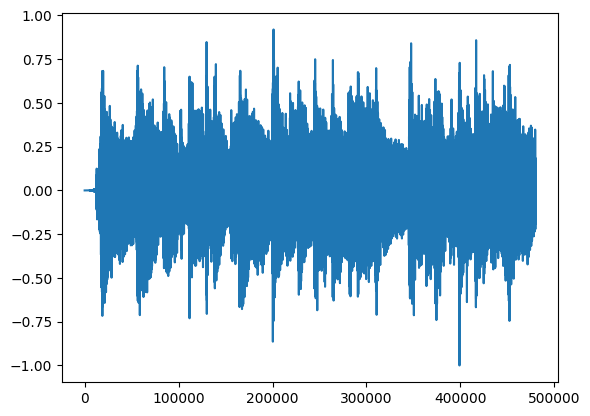

In [2]:
import numpy as np
from scipy.io.wavfile import read, write
import sounddevice as sd
import matplotlib.pyplot as plt

sample_rate, data = read('clean_guitar_sample.wav')
data = data/np.max(np.abs(data), axis=0)

plt.plot(range(len(data)), data)

if PLAY_SOUND:
    sd.play(data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## Dynamic Range Compressor
https://www.mathworks.com/help/audio/ref/compressor-system-object.html

In [3]:
from math import log10, exp, log

class DynamicRangeCompressor:
    def __init__(
            self,
            threshold=-10,
            ratio=5,
            knee_width=0, # Hard knee if knee_width == 0 or None
            attack_time=0.05,
            release_time=0.2,
            makeup_gain=None, # Make-up gain in dB. Calculated automatically (gain computed with 0 dB input) if set to None
            sample_rate=44100):
        self.threshold = threshold
        self.ratio = ratio
        self.knee_width = knee_width
        self.attack_time = attack_time
        self.release_time = release_time
        self.makeup_gain = makeup_gain
        self.sample_rate = sample_rate

    def compress(self, data):
        def calc_x_sc(x_db):
            if not self.knee_width:
                if x_db < (self.threshold - self.knee_width/2):
                    return x_db
                elif x_db >= (self.threshold - self.knee_width/2) and x_db <= (self.threshold + self.knee_width/2):
                    return x_db + (1/self.ratio-1)*((x_db-self.threshold+self.knee_width/2)**2)/(2*self.knee_width)
                else:
                    return self.threshold + (x_db - self.threshold)/self.ratio
            else:
                if x_db < self.threshold:
                    return x_db
                else:
                    return self.threshold + (x_db - self.threshold)/self.ratio

        output = np.zeros(len(data))
        gain = np.zeros(len(data))

        data_max = np.max(np.abs(data),axis=0)
        data = data/data_max # Normalise between -1 and 1

        # Calculate make-up gain
        # Make-up gain is the negative of the computed gain for a 0 dB input
        makeup_gain = self.makeup_gain if self.makeup_gain != None else -calc_x_sc(0)

        g_s_prev = 0 # g_s[i-1]. Default is low enough such that there is no 'click'
        for i in range(0, len(data)):
            # Convert input signal into decibels
            try:
                x_db = 20 * log10(abs(data[i]))
            except:
                # If data[i] == 0
                x_db = 0

            # Gain computer
            x_sc = calc_x_sc(x_db)

            g_c = x_sc - x_db # Computed gain

            # Gain smoothing
            alpha_a = exp(-log(9)/(self.sample_rate*self.attack_time))
            alpha_r = exp(-log(9)/(self.sample_rate*self.release_time))

            if g_c <= g_s_prev:
                g_s = alpha_a*g_s_prev + (1-alpha_a)*g_c
            else:
                g_s = alpha_r*g_s_prev + (1-alpha_r)*g_c

            g_s_prev = g_s

            # Apply makeup_gain
            g_m = g_s + makeup_gain
            gain[i] = g_m

            # Calculate and apply linear gain
            g_lin = 10**(g_m/20)
            output[i] = data[i] * g_lin

        # output *= data_max # Reverse the normalisation

        return output, gain

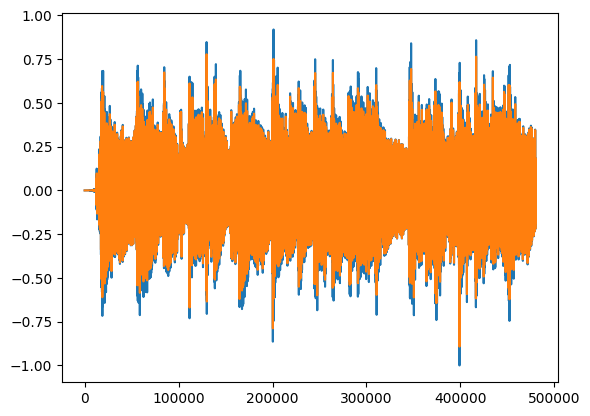

In [4]:
compressor = DynamicRangeCompressor(threshold=-10, knee_width=10, attack_time=0.01, makeup_gain=0)
compressed_data, gain = compressor.compress(data)

plt.plot(range(len(compressed_data)), data)
plt.plot(range(len(compressed_data)), compressed_data)

# plt.plot(range(len(compressed_data)), gain)

if PLAY_SOUND:
    sd.play(compressed_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## Low-Pass Filter

In [5]:
from tqdm import tqdm

# Analysis of response
def magnitude_response(func):
    # Magnitude Response
    frequencies = range(20, 20000, 100)
    magnitude = []
    for f in tqdm(frequencies):
        input_data = np.sin(np.linspace(0, 1, 44100) * f * 2*np.pi)
        output_data = func(input_data)
        magnitude.append(max(output_data[len(output_data)//2:])) # Taking second half of response only for steady state

    plt.plot(frequencies, magnitude)
    plt.show()

100%|██████████| 200/200 [00:15<00:00, 13.02it/s]


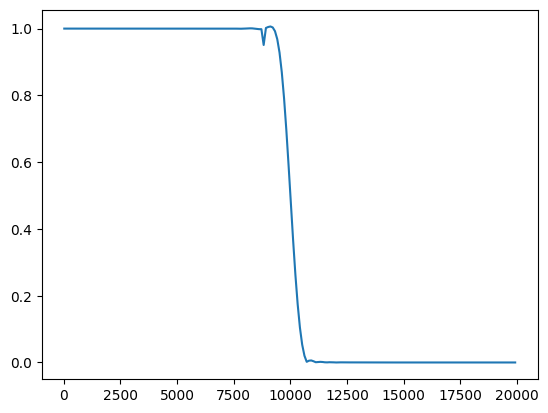

In [6]:
from math import sin

# Finite Impulse Response Low-Pass Filter
class LowPassFilter:
    def __init__(
            self,
            freq_thresh=10000,
            filter_shift=100,
            sample_rate=44100):
        self.freq_thresh = freq_thresh
        self.filter_shift = filter_shift
        self.sample_rate = sample_rate
        
        # Calculate discrete theta (in radians)
        theta = (self.freq_thresh * 2*np.pi) / self.sample_rate

        # Calculate filter (sinc function)
        def sinc(k):
            if k != 0:
                return sin(k*theta) / (np.pi*k)
            else:
                return theta/np.pi # L' Hopital's

        lp_filter = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2))

        # Calculate Hanning window
        hanning = 0.5 - 0.5*np.cos(2*np.pi*np.arange(0, self.filter_shift, 1)/self.filter_shift)

        # Apply window
        self.lp_filter = np.multiply(hanning, lp_filter)

    def filter(self, data):
        output = np.zeros(len(data))
        data = np.concatenate((np.zeros(self.filter_shift), data))
        
        for i in range(self.filter_shift, len(data)):
            output[i-self.filter_shift] = np.dot(self.lp_filter, data[i-self.filter_shift:i])

        return output

lp_filter = LowPassFilter(freq_thresh=10000)

# Magnitude Response
if ANALYSE_MAGNITUDE: magnitude_response(lp_filter.filter)

100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


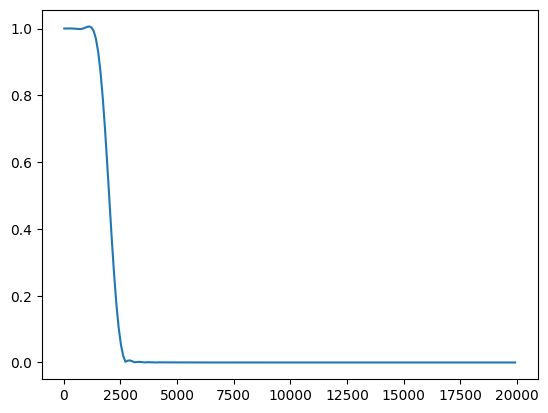

In [7]:
lp_filter = LowPassFilter(freq_thresh=2000)
lp_data = lp_filter.filter(data)

if ANALYSE_MAGNITUDE: magnitude_response(lp_filter.filter)

if PLAY_SOUND:
    sd.play(lp_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## High Pass Filter
https://www.vyssotski.ch/BasicsOfInstrumentation/SpikeSorting/Design_of_FIR_Filters.pdf

100%|██████████| 200/200 [00:15<00:00, 12.98it/s]


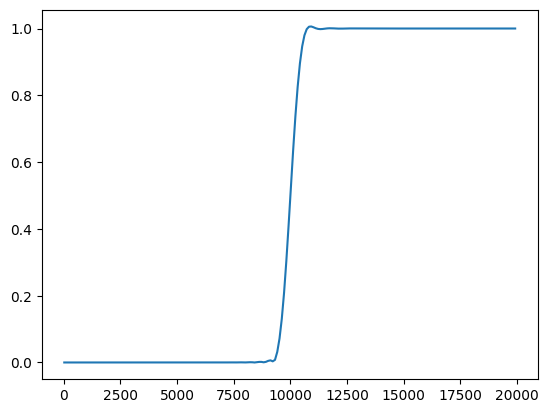

In [8]:
from math import sin, cos

# Finite Impulse Response High-Pass Filter
class HighPassFilter:
    def __init__(
            self,
            freq_thresh=10000,
            filter_shift=100,
            sample_rate=44100):
        self.freq_thresh = freq_thresh
        self.filter_shift = filter_shift
        self.sample_rate = sample_rate
        
        # Calculate discrete theta (in radians)
        theta = (self.freq_thresh * 2*np.pi) / self.sample_rate

        # Calculate filter (sinc function)
        def sinc(k, th):
            if k != 0:
                return cos(np.pi*k/sample_rate) * sin(k*th) / (np.pi*k)
            else:
                return th/np.pi # L' Hopital's

        # High-pass filter built as follows:
        # Low-pass filter (threshold=pi) - Low-pass filter (threshold=freq_thresh)
        lp_pi = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), np.pi)
        lp_1 = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), theta)
        hp_filter = lp_pi - lp_1

        # Calculate Hanning window
        hanning = 0.5 - 0.5*np.cos(2*np.pi*np.arange(0, self.filter_shift, 1)/self.filter_shift)

        # Apply window
        hp_filter = np.multiply(hanning, hp_filter)

        self.hp_filter = hp_filter

    def filter(self, data):
        output = np.zeros(len(data))
        data = np.concatenate((np.zeros(self.filter_shift), data))
        
        for i in range(self.filter_shift, len(data)):
            output[i-self.filter_shift] = np.dot(self.hp_filter, data[i-self.filter_shift:i])

        return output

hp_filter = HighPassFilter(freq_thresh=10000)

# Magnitude Response
if ANALYSE_MAGNITUDE: magnitude_response(hp_filter.filter)

100%|██████████| 200/200 [00:15<00:00, 12.98it/s]


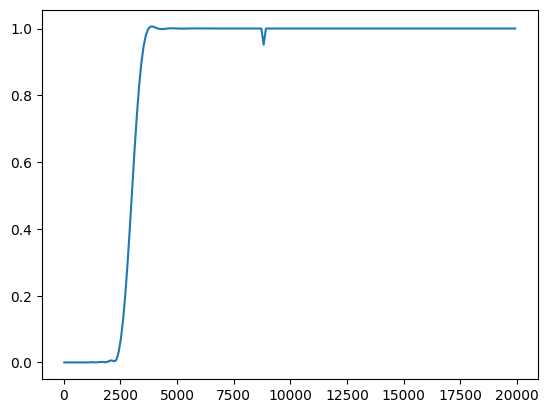

In [9]:
hp_filter = HighPassFilter(freq_thresh=3000)
hp_data = hp_filter.filter(data)

if ANALYSE_MAGNITUDE: magnitude_response(hp_filter.filter)

if PLAY_SOUND:
    sd.play(hp_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## Band-Pass Filter

100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


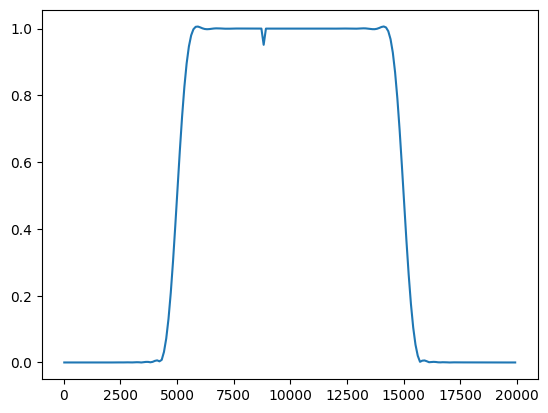

In [10]:
from math import sin

# Finite Impulse Response Band-Pass Filter
class BandPassFilter:
    def __init__(
            self,
            low_thresh=5000,
            high_thresh=15000,
            filter_shift=100,
            sample_rate=44100):
        self.low_thresh = low_thresh
        self.high_thresh = high_thresh
        self.filter_shift = filter_shift
        self.sample_rate = sample_rate
        
        # Calculate discrete theta (in radians)
        theta_1 = (self.low_thresh * 2*np.pi) / self.sample_rate
        theta_2 = (self.high_thresh * 2*np.pi) / self.sample_rate

        # Calculate filter (sinc function)
        def sinc(k, theta):
            if k != 0:
                return sin(k*theta) / (np.pi*k)
            else:
                return theta/np.pi # L' Hopital's

        # Calculate low-pass filter to invert
        lp_filter_1 = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), theta_1)

        # Calculate low-pass filter to add
        lp_filter_2 = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), theta_2)

        # Combine filters
        bp_filter = lp_filter_2 - lp_filter_1

        # Calculate Hanning window
        hanning = 0.5 - 0.5*np.cos(2*np.pi*np.arange(0, self.filter_shift, 1)/self.filter_shift)

        # Apply window
        bp_filter = np.multiply(hanning, bp_filter)

        self.bp_filter = bp_filter

    def filter(self, data):
        output = np.zeros(len(data))
        data = np.concatenate((np.zeros(self.filter_shift), data))
        
        for i in range(self.filter_shift, len(data)):
            output[i-self.filter_shift] = np.dot(self.bp_filter, data[i-self.filter_shift:i])

        return output

bp_filter = BandPassFilter()

# Magnitude Response
if ANALYSE_MAGNITUDE: magnitude_response(bp_filter.filter)

100%|██████████| 200/200 [00:15<00:00, 12.78it/s]


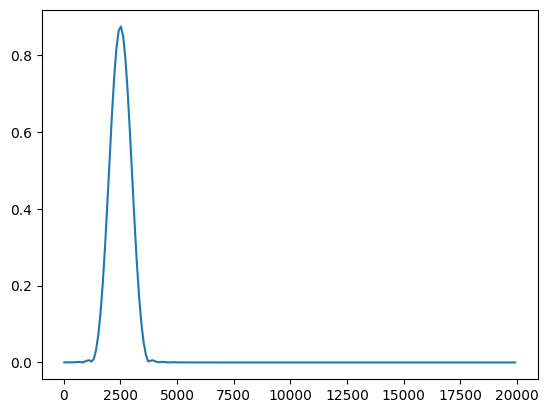

In [11]:
bp_filter = BandPassFilter(low_thresh=2000, high_thresh=3000)
bp_data = bp_filter.filter(data)

if ANALYSE_MAGNITUDE: magnitude_response(bp_filter.filter)

if PLAY_SOUND:
    sd.play(bp_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing